<a href="https://colab.research.google.com/github/gez2code/Binary-Classification-DermaMNIST/blob/main/Binary_Classification_DermaMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Block 1: Installation, Imports & Setup

This section initializes the environment for the DermaMNIST classification study.

Contents:

Install dependencies (medmnist, wandb)
Import libraries (TensorFlow, Keras, sklearn, etc.)
Set random seeds for reproducibility (SEED=42)
Mount Google Drive and create folder structure
Define save function for model checkpoints
Folder Structure:

Phase1_Baselines: Architecture comparison
Phase2_Tuning: Hyperparameter optimization
Phase3_Final: Best model evaluation




In [1]:
# ============================================================================
# BLOCK 1: INSTALLATION, IMPORTS & SETUP
# ============================================================================
!pip install medmnist wandb

import os
import random
import gc
import shutil  # ← Moved here (only once)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# Metrics & Data
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from sklearn.utils import class_weight
from medmnist import DermaMNIST

# Tracking
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# Google Colab
from google.colab import drive

# ============================================================================
# REPRODUCIBILITY
# ============================================================================
SEED = 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()
print(f"✓ Setup complete. TensorFlow Version: {tf.__version__}")

# ============================================================================
# GOOGLE DRIVE SETUP (Organized by Phase)
# ============================================================================
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/DermaMNIST_Study'
DIR_PHASE_1 = os.path.join(BASE_PATH, 'Phase1_Baselines')
DIR_PHASE_2 = os.path.join(BASE_PATH, 'Phase2_Tuning')
DIR_PHASE_3 = os.path.join(BASE_PATH, 'Phase3_Final')

for folder in [DIR_PHASE_1, DIR_PHASE_2, DIR_PHASE_3]:
    os.makedirs(folder, exist_ok=True)

print(f"✅ Folder structure created:")
print(f"   📂 Phase 1 -> {DIR_PHASE_1}")
print(f"   📂 Phase 2 -> {DIR_PHASE_2}")
print(f"   📂 Phase 3 -> {DIR_PHASE_3}")

# ============================================================================
# SAVE FUNCTION
# ============================================================================
def save_to_drive(experiment_name, target_folder):
    """Save model to specific phase folder"""
    filename = f"{experiment_name}.keras"
    source = filename
    destination = os.path.join(target_folder, filename)

    if os.path.exists(source):
        shutil.copy(source, destination)
        print(f"💾 SAVED: {filename} -> {target_folder}")
    else:
        print(f"⚠️ ERROR: {filename} not found!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.6 MB/s eta 0:00:00
✓ Setup complete. TensorFlow Version: 2.19.0
Mounted at /content/drive
✅ Folder structure created:
   📂 Phase 1 -> /content/drive/MyDrive/DermaMNIST_Study/Phase1_Baselines
   📂 Phase 2 -> /content/drive/MyDrive/DermaMNIST_Study/Phase2_Tuning
   📂 Phase 3 -> /content/drive/MyDrive/DermaMNIST_Study/Phase3_Final


# Block 2: Data Loading & Exploratory Data Analysis

This section loads the DermaMNIST dataset and performs EDA before and after transformation.

Structure:
- 2a: Explore raw data (7 classes, original pixels)
- 2b: Transform data (normalize, binary mapping, augmentation)
- 2c: Verify transformed data (2 classes, class imbalance ~9:1)

Dataset: DermaMNIST (28x28 RGB dermatology images)
Task: Binary classification - Malignant (1) vs Benign (0)

📊 EXPLORATORY DATA ANALYSIS - RAW DATA


100%|██████████| 19.7M/19.7M [00:14<00:00, 1.33MB/s]



1️⃣ DATASET OVERVIEW
----------------------------------------
   Training samples:   7,007
   Validation samples: 1,003
   Test samples:       2,005
   Total samples:      10,015

2️⃣ IMAGE PROPERTIES
----------------------------------------
   Shape: (28, 28, 3)
   Dtype: uint8
   Pixel range: [0, 255]

3️⃣ ORIGINAL LABEL DISTRIBUTION (7 Classes)
----------------------------------------
   Class                                 Count  Percent
   ----------------------------------- ------- --------
   Melanocytic nevi (nv)                   228     3.3%
   Melanoma (mel)                          359     5.1%
   Benign keratosis (bkl)                  769    11.0%
   Basal cell carcinoma (bcc)               80     1.1%
   Actinic keratoses (akiec)               779    11.1%
   Vascular lesions (vasc)               4,693    67.0%
   Dermatofibroma (df)                      99     1.4%


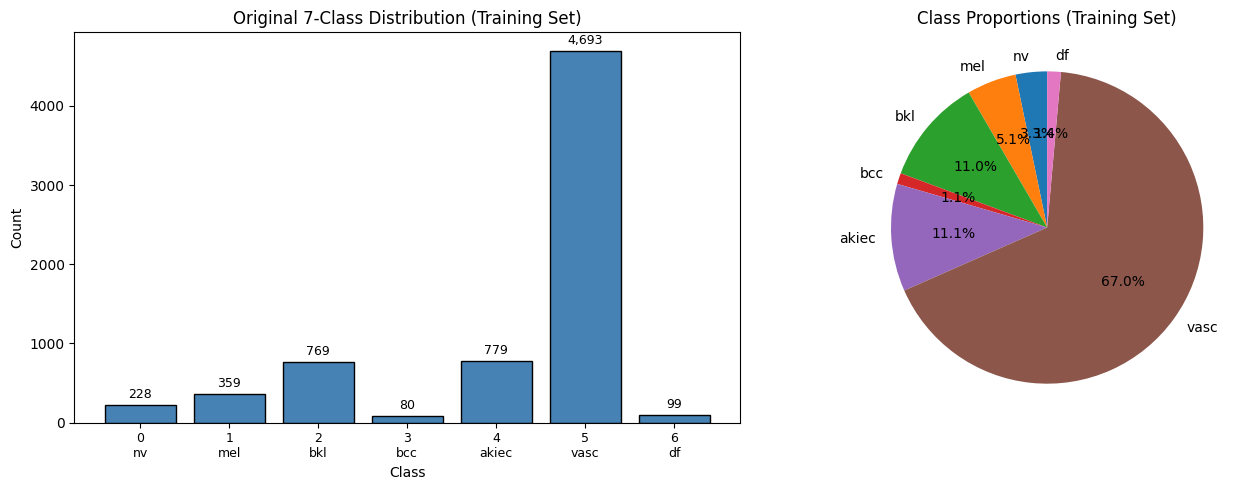


4️⃣ SAMPLE IMAGES FROM EACH CLASS
----------------------------------------


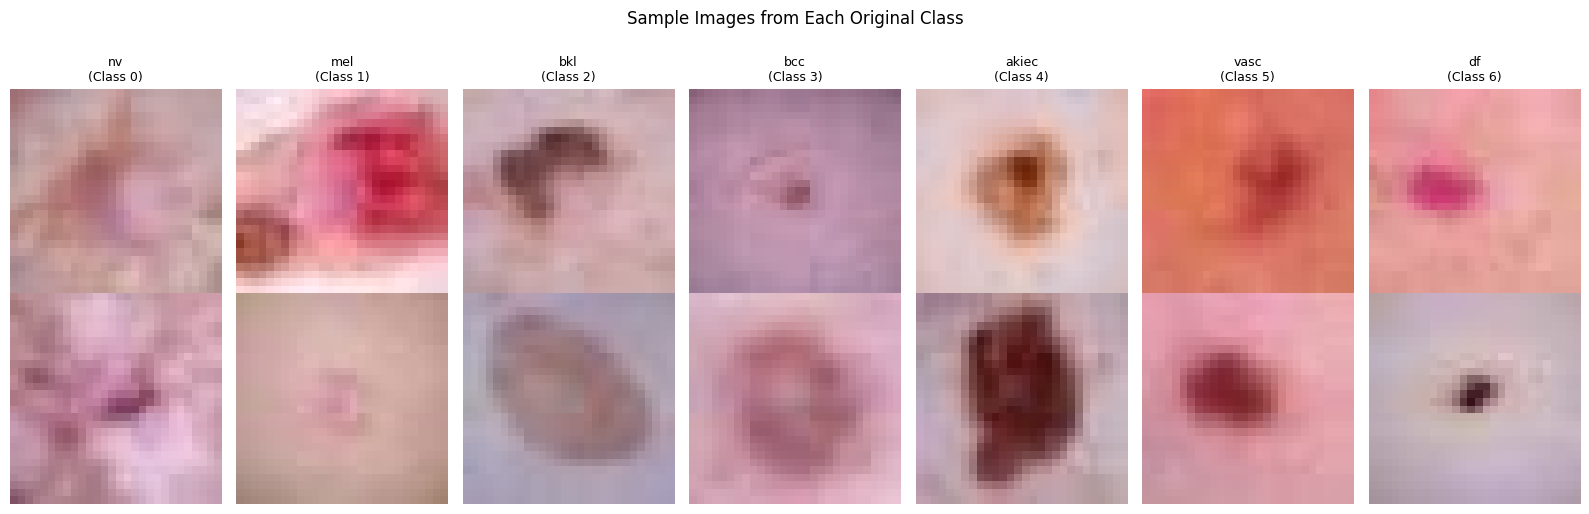


5️⃣ BINARY MAPPING PREVIEW
----------------------------------------
   Malignant (1): Classes 0, 1, 6
      - 0: Melanocytic nevi (nv)
      - 1: Melanoma (mel)
      - 6: Dermatofibroma (df)

   Benign (0): Classes 2, 3, 4, 5
      - 2: Benign keratosis (bkl)
      - 3: Basal cell carcinoma (bcc)
      - 4: Actinic keratoses (akiec)
      - 5: Vascular lesions (vasc)

   Expected after transformation:
      Benign:    6,321 (90.2%)
      Malignant: 686 (9.8%)
      Ratio:     9.2:1 (Benign:Malignant)


In [2]:
# ============================================================================
# BLOCK 2a: EDA - RAW DATA EXPLORATION
# ============================================================================

print("="*60)
print("📊 EXPLORATORY DATA ANALYSIS - RAW DATA")
print("="*60)

# Load raw data (before any transformation)
raw_train = DermaMNIST(split='train', download=True, size=28)
raw_val = DermaMNIST(split='val', download=True, size=28)
raw_test = DermaMNIST(split='test', download=True, size=28)

# 1. Dataset Overview
print("\n1️⃣ DATASET OVERVIEW")
print("-"*40)
print(f"   Training samples:   {len(raw_train.imgs):,}")
print(f"   Validation samples: {len(raw_val.imgs):,}")
print(f"   Test samples:       {len(raw_test.imgs):,}")
print(f"   Total samples:      {len(raw_train.imgs) + len(raw_val.imgs) + len(raw_test.imgs):,}")

# 2. Image Properties
print("\n2️⃣ IMAGE PROPERTIES")
print("-"*40)
print(f"   Shape: {raw_train.imgs[0].shape}")
print(f"   Dtype: {raw_train.imgs[0].dtype}")
print(f"   Pixel range: [{raw_train.imgs.min()}, {raw_train.imgs.max()}]")

# 3. Original Label Distribution (7 classes in DermaMNIST)
print("\n3️⃣ ORIGINAL LABEL DISTRIBUTION (7 Classes)")
print("-"*40)

# DermaMNIST original classes
class_names = {
    0: 'Melanocytic nevi (nv)',
    1: 'Melanoma (mel)',
    2: 'Benign keratosis (bkl)',
    3: 'Basal cell carcinoma (bcc)',
    4: 'Actinic keratoses (akiec)',
    5: 'Vascular lesions (vasc)',
    6: 'Dermatofibroma (df)'
}

# Count each class
train_labels = raw_train.labels.flatten()
unique, counts = np.unique(train_labels, return_counts=True)

print(f"   {'Class':<35} {'Count':>7} {'Percent':>8}")
print(f"   {'-'*35} {'-'*7} {'-'*8}")
for cls, count in zip(unique, counts):
    pct = 100 * count / len(train_labels)
    print(f"   {class_names[cls]:<35} {count:>7,} {pct:>7.1f}%")

# 4. Visualize Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
bars = ax1.bar(range(len(unique)), counts, color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(unique)))
ax1.set_xticklabels([f"{i}\n{class_names[i].split('(')[1].replace(')', '')}" for i in unique], fontsize=9)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Original 7-Class Distribution (Training Set)')

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Pie chart
ax2 = axes[1]
ax2.pie(counts, labels=[class_names[i].split('(')[1].replace(')', '') for i in unique],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Proportions (Training Set)')

plt.tight_layout()
plt.show()

# 5. Sample Images from Each Class
print("\n4️⃣ SAMPLE IMAGES FROM EACH CLASS")
print("-"*40)

fig, axes = plt.subplots(2, 7, figsize=(16, 5))

for cls in range(7):
    # Get samples of this class
    cls_indices = np.where(train_labels == cls)[0]

    # Show 2 samples per class
    for row in range(2):
        idx = cls_indices[row]
        axes[row, cls].imshow(raw_train.imgs[idx])
        axes[row, cls].axis('off')
        if row == 0:
            short_name = class_names[cls].split('(')[1].replace(')', '')
            axes[row, cls].set_title(f'{short_name}\n(Class {cls})', fontsize=9)

plt.suptitle('Sample Images from Each Original Class', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# 6. Binary Mapping Preview
print("\n5️⃣ BINARY MAPPING PREVIEW")
print("-"*40)
print("   Malignant (1): Classes 0, 1, 6")
print("      - 0: Melanocytic nevi (nv)")
print("      - 1: Melanoma (mel)")
print("      - 6: Dermatofibroma (df)")
print("\n   Benign (0): Classes 2, 3, 4, 5")
print("      - 2: Benign keratosis (bkl)")
print("      - 3: Basal cell carcinoma (bcc)")
print("      - 4: Actinic keratoses (akiec)")
print("      - 5: Vascular lesions (vasc)")

# Calculate expected binary distribution
malignant_classes = [0, 1, 6]
malignant_count = sum(counts[i] for i in range(len(unique)) if unique[i] in malignant_classes)
benign_count = sum(counts[i] for i in range(len(unique)) if unique[i] not in malignant_classes)

print(f"\n   Expected after transformation:")
print(f"      Benign:    {benign_count:,} ({100*benign_count/len(train_labels):.1f}%)")
print(f"      Malignant: {malignant_count:,} ({100*malignant_count/len(train_labels):.1f}%)")
print(f"      Ratio:     {benign_count/malignant_count:.1f}:1 (Benign:Malignant)")

In [3]:
# ============================================================================
# BLOCK 2b: DATA LOADING & PREPROCESSING
# ============================================================================

def load_and_preprocess_data():
    print("\n" + "="*60)
    print("🔄 DATA TRANSFORMATION")
    print("="*60)

    train_data = DermaMNIST(split='train', download=True, size=28)
    val_data = DermaMNIST(split='val', download=True, size=28)
    test_data = DermaMNIST(split='test', download=True, size=28)

    # Normalize: [0, 255] → [0, 1]
    print("\n1️⃣ Normalizing pixel values: [0, 255] → [0, 1]")
    x_train = train_data.imgs.astype('float32') / 255.0
    x_val = val_data.imgs.astype('float32') / 255.0
    x_test = test_data.imgs.astype('float32') / 255.0

    # Binary mapping: Malignant (1) vs Benign (0)
    print("2️⃣ Converting to binary: 7 classes → 2 classes")
    to_binary = lambda y: np.isin(y, [0, 1, 6]).astype(int)
    y_train_bin = to_binary(train_data.labels)
    y_val_bin = to_binary(val_data.labels)
    y_test_bin = to_binary(test_data.labels)

    # One-hot encode
    print("3️⃣ One-hot encoding labels")
    y_train = tf.keras.utils.to_categorical(y_train_bin, 2)
    y_val = tf.keras.utils.to_categorical(y_val_bin, 2)
    y_test = tf.keras.utils.to_categorical(y_test_bin, 2)

    # Class weights
    class_weights = None  # Will be set in 6

    return {
        'x_train': x_train, 'y_train': y_train, 'y_train_bin': y_train_bin,
        'x_val': x_val, 'y_val': y_val, 'y_val_bin': y_val_bin,
        'x_test': x_test, 'y_test': y_test, 'y_test_bin': y_test_bin,
        'class_weights': class_weights
    }

def get_augmentation_generator(seed=SEED):
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

# Load and transform data
data = load_and_preprocess_data()
datagen = get_augmentation_generator(seed=SEED)


🔄 DATA TRANSFORMATION

1️⃣ Normalizing pixel values: [0, 255] → [0, 1]
2️⃣ Converting to binary: 7 classes → 2 classes
3️⃣ One-hot encoding labels



📊 EXPLORATORY DATA ANALYSIS - TRANSFORMED DATA

1️⃣ TRANSFORMED DATA OVERVIEW
----------------------------------------
   Split        Shape                Dtype        Pixel Range
   ------------ -------------------- ------------ ---------------
   Train        (7007, 28, 28, 3)    float32      [0.00, 1.00]
   Val          (1003, 28, 28, 3)    float32      [0.00, 1.00]
   Test         (2005, 28, 28, 3)    float32      [0.00, 1.00]

2️⃣ BINARY LABEL DISTRIBUTION
----------------------------------------
   Train:
      Benign (0):    6,321 ( 90.2%)
      Malignant (1):   686 (  9.8%)
      Ratio: 9.2:1

   Val:
      Benign (0):      904 ( 90.1%)
      Malignant (1):    99 (  9.9%)
      Ratio: 9.1:1

   Test:
      Benign (0):    1,807 ( 90.1%)
      Malignant (1):   198 (  9.9%)
      Ratio: 9.1:1



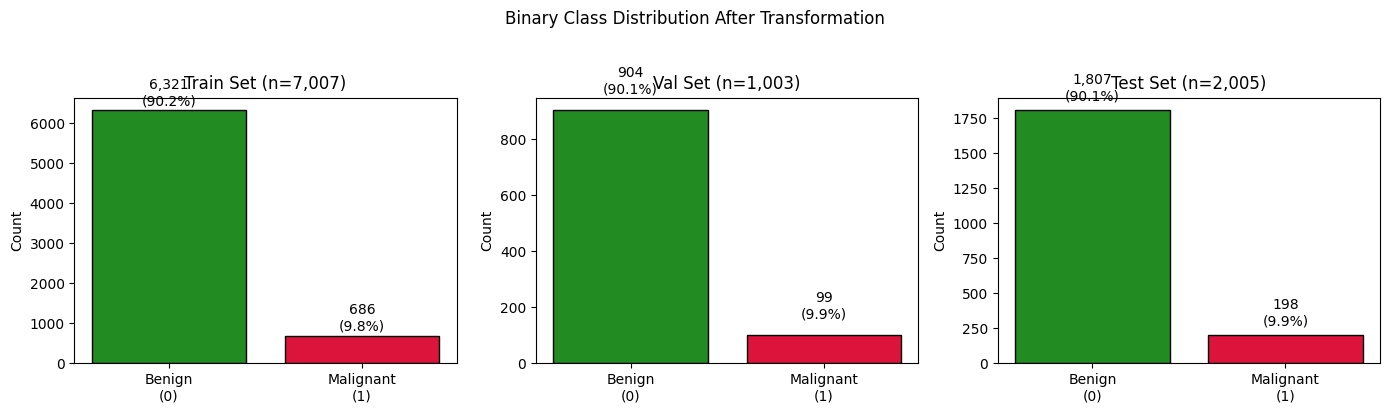


3️⃣ SAMPLE IMAGES BY BINARY CLASS
----------------------------------------


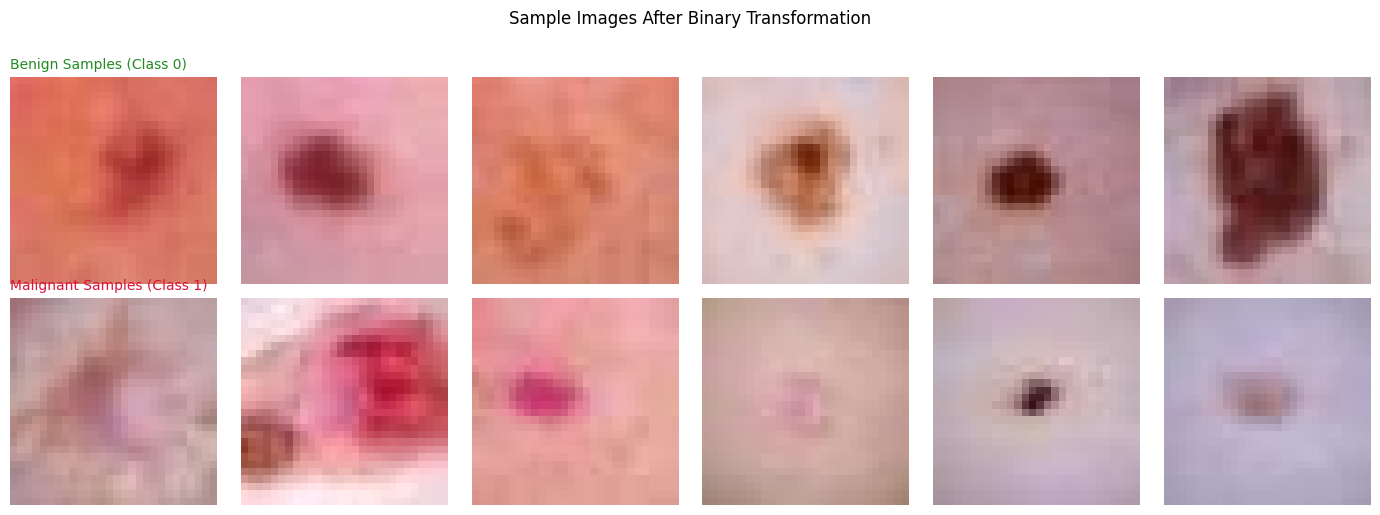


4️⃣ ONE-HOT ENCODING VERIFICATION
----------------------------------------
   y_train shape: (7007, 2)
   y_train sample (first 5):
   [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

5️⃣ DATA AUGMENTATION PREVIEW
----------------------------------------


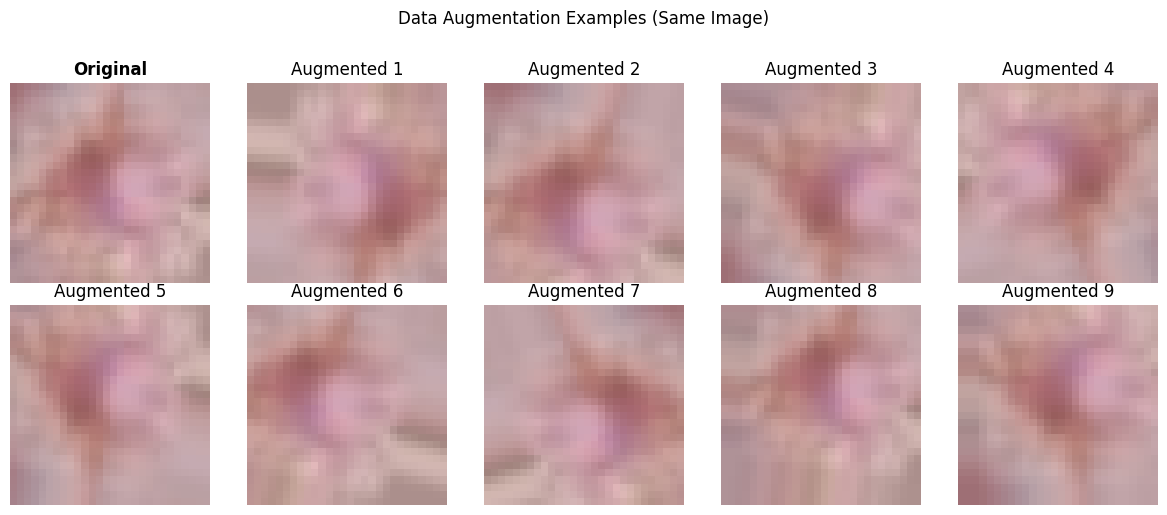


6️⃣ CLASS IMBALANCE SUMMARY
----------------------------------------
   ⚠️  Your data is IMBALANCED
   
   Benign:Malignant ratio = ~9:1
   
   Without intervention, model will likely:
      • Predict 'Benign' most of the time (90% accuracy!)
      • Have LOW recall for Malignant class
   
   Strategies to address:
      • Class weights: {0: 1.0, 1: 3.0} or higher
      • Oversampling (SMOTE)
      • Focal loss

✅ EDA COMPLETE - Ready for modeling


In [4]:
# ============================================================================
# BLOCK 2c: EDA - TRANSFORMED DATA
# ============================================================================

print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS - TRANSFORMED DATA")
print("="*60)

# 1. Transformed Data Overview
print("\n1️⃣ TRANSFORMED DATA OVERVIEW")
print("-"*40)
print(f"   {'Split':<12} {'Shape':<20} {'Dtype':<12} {'Pixel Range'}")
print(f"   {'-'*12} {'-'*20} {'-'*12} {'-'*15}")
print(f"   {'Train':<12} {str(data['x_train'].shape):<20} {str(data['x_train'].dtype):<12} [{data['x_train'].min():.2f}, {data['x_train'].max():.2f}]")
print(f"   {'Val':<12} {str(data['x_val'].shape):<20} {str(data['x_val'].dtype):<12} [{data['x_val'].min():.2f}, {data['x_val'].max():.2f}]")
print(f"   {'Test':<12} {str(data['x_test'].shape):<20} {str(data['x_test'].dtype):<12} [{data['x_test'].min():.2f}, {data['x_test'].max():.2f}]")

# 2. Binary Label Distribution
print("\n2️⃣ BINARY LABEL DISTRIBUTION")
print("-"*40)

for split_name, y_bin in [('Train', data['y_train_bin']),
                           ('Val', data['y_val_bin']),
                           ('Test', data['y_test_bin'])]:
    total = len(y_bin)
    malignant = y_bin.sum()
    benign = total - malignant
    print(f"   {split_name}:")
    print(f"      Benign (0):    {benign:>5,} ({100*benign/total:>5.1f}%)")
    print(f"      Malignant (1): {int(malignant):>5,} ({100*malignant/total:>5.1f}%)")
    print(f"      Ratio: {benign/malignant:.1f}:1")
    print()

# 3. Visualize Binary Distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (split_name, y_bin) in zip(axes, [('Train', data['y_train_bin']),
                                           ('Val', data['y_val_bin']),
                                           ('Test', data['y_test_bin'])]):
    total = len(y_bin)
    malignant = int(y_bin.sum())
    benign = total - malignant

    bars = ax.bar(['Benign\n(0)', 'Malignant\n(1)'], [benign, malignant],
                  color=['forestgreen', 'crimson'], edgecolor='black')
    ax.set_title(f'{split_name} Set (n={total:,})')
    ax.set_ylabel('Count')

    # Add labels
    for bar, count in zip(bars, [benign, malignant]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}\n({100*count/total:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.suptitle('Binary Class Distribution After Transformation', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# 4. Sample Images by Binary Class
print("\n3️⃣ SAMPLE IMAGES BY BINARY CLASS")
print("-"*40)

fig, axes = plt.subplots(2, 6, figsize=(14, 5))

y_train_flat = data['y_train_bin'].flatten()

for row, (cls, cls_name, color) in enumerate([(0, 'Benign', 'forestgreen'),
                                                (1, 'Malignant', 'crimson')]):
    cls_indices = np.where(y_train_flat == cls)[0]

    for col in range(6):
        idx = cls_indices[col]
        axes[row, col].imshow(data['x_train'][idx])
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(cls_name, fontsize=12, color=color, fontweight='bold')

axes[0, 0].set_title('Benign Samples (Class 0)', fontsize=10, loc='left', color='forestgreen')
axes[1, 0].set_title('Malignant Samples (Class 1)', fontsize=10, loc='left', color='crimson')

plt.suptitle('Sample Images After Binary Transformation', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# 5. One-Hot Encoding Verification
print("\n4️⃣ ONE-HOT ENCODING VERIFICATION")
print("-"*40)
print(f"   y_train shape: {data['y_train'].shape}")
print(f"   y_train sample (first 5):")
print(f"   {data['y_train'][:5]}")

# 6. Data Augmentation Preview
print("\n5️⃣ DATA AUGMENTATION PREVIEW")
print("-"*40)

# Pick one sample
sample_idx = np.where(data['y_train_bin'].flatten() == 1)[0][0]  # First malignant
sample_img = data['x_train'][sample_idx:sample_idx+1]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Original
axes[0, 0].imshow(sample_img[0])
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Augmented versions
aug_iter = datagen.flow(sample_img, batch_size=1, seed=SEED)
for i in range(1, 10):
    row = i // 5
    col = i % 5
    aug_img = next(aug_iter)[0]
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples (Same Image)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# 7. Class Imbalance Summary
print("\n6️⃣ CLASS IMBALANCE SUMMARY")
print("-"*40)
print(f"   ⚠️  Your data is IMBALANCED")
print(f"   ")
print(f"   Benign:Malignant ratio = ~9:1")
print(f"   ")
print(f"   Without intervention, model will likely:")
print(f"      • Predict 'Benign' most of the time (90% accuracy!)")
print(f"      • Have LOW recall for Malignant class")
print(f"   ")
print(f"   Strategies to address:")
print(f"      • Class weights: {'{0: 1.0, 1: 3.0}'} or higher")
print(f"      • Oversampling (SMOTE)")
print(f"      • Focal loss")

print("\n" + "="*60)
print("✅ EDA COMPLETE - Ready for modeling")
print("="*60)

# BLOCK 3: MODEL ARCHITECTURES

In [5]:
# ============================================================================
# BLOCK 3: MODEL ARCHITECTURES
# ============================================================================
def build_custom_cnn(filters_base=32, depth=3, dropout=0.5, dense_units=512):
    model = models.Sequential([layers.Input(shape=(28, 28, 3))])
    for i in range(depth):
        filters = filters_base * (2 ** i)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout * (0.5 + i*0.25)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2, activation='softmax'))
    return model

def build_transfer_model(base_name='resnet50', dropout=0.5, unfreeze_layers=None, dense_units=256):
    inputs = layers.Input(shape=(28, 28, 3))
    # Upsampling is crucial for pre-trained models
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)

    base_models = {
        'resnet50': lambda: ResNet50(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),
        'vgg16': lambda: VGG16(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),
        'efficientnet': lambda: EfficientNetB0(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg')
    }

    if base_name not in base_models: raise ValueError(f"Unknown base: {base_name}")
    base = base_models[base_name]()

    # Fine-tuning logic
    if unfreeze_layers is None:
        base.trainable = True # Full fine-tuning
    elif unfreeze_layers == 0:
        base.trainable = False # Feature extraction
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    x = base(x, training=False)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout * 0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs, name=f"{base_name}_model")

# BLOCK 4: TRAINING CONFIGURATION & HELPERS

In [6]:
# ============================================================================
# BLOCK 4: TRAINING CONFIGURATION & HELPERS
# ============================================================================

def compile_model(model, learning_rate):
    """Single definition with all metrics"""
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(class_id=1, name='precision'),
            tf.keras.metrics.Recall(class_id=1, name='recall')
        ]
    )

def get_callbacks(config, model_path):
    return [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=config['patience'],
            mode='min',
            restore_best_weights=True,  # ← Restore best loss model
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='val_loss',          # ← Save best loss model
            mode='min',
            save_best_only=True,
            verbose=1
        ),
        WandbMetricsLogger(log_freq='epoch'),
        WandbModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

def compute_metrics(model, data_dict, split_name):
    """Compute essential metrics on full dataset"""
    y_pred_probs = model.predict(data_dict['x'], verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(data_dict['y'], axis=1)

    metrics = {
        f'{split_name}/auc': roc_auc_score(data_dict['y'], y_pred_probs),
        f'{split_name}/recall_mal': recall_score(y_true_classes, y_pred_classes, pos_label=1, zero_division=0),
        f'{split_name}/precision_mal': precision_score(y_true_classes, y_pred_classes, pos_label=1, zero_division=0),
        f'{split_name}/f1_mal': f1_score(y_true_classes, y_pred_classes, pos_label=1, zero_division=0)
    }

    return metrics, confusion_matrix(y_true_classes, y_pred_classes)

# BLOCK 5: MAIN TRAINING LOOP (FIXED)

In [7]:
# ============================================================================
# BLOCK 5: MAIN TRAINING LOOP (WITH CONFUSION MATRIX)
# ============================================================================
def train_experiment(config, data, datagen):
    print(f"\n{'='*60}")
    print(f"🚀 STARTING: {config['name']}")
    print(f"{'='*60}")

    model = None
    run = None

    try:
        # 1. Init W&B
        if wandb.run is not None:
            wandb.finish()
        run = wandb.init(
            project="DermaMNIST_Study",
            name=config['name'],
            config=config,
            reinit=True,
            id=wandb.util.generate_id()
        )

        # 2. Build Model
        if config['architecture'] == 'custom_cnn':
            model = build_custom_cnn(
                config['filters_base'],
                config['depth'],
                config['dropout'],
                config['dense_units']
            )
        else:
            model = build_transfer_model(
                config['architecture'],
                config['dropout'],
                config['unfreeze_layers'],
                config['dense_units']
            )

        compile_model(model, config['learning_rate'])
        model_path = f"{config['name']}.keras"

        # 3. Create infinite dataset
        train_gen = datagen.flow(
            data['x_train'],
            data['y_train'],
            batch_size=config['batch_size'],
            seed=SEED
        )
        steps = len(data['x_train']) // config['batch_size']

        train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen,
            output_signature=(
                tf.TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
            )
        ).repeat()

        # 4. Train
        history = model.fit(
            train_dataset,
            steps_per_epoch=steps,
            epochs=config['epochs'],
            validation_data=(data['x_val'], data['y_val']),
            class_weight=data['class_weights'],
            callbacks=get_callbacks(config, model_path),
            verbose=1
        )

        # 5. FIND BEST METRICS (Summary)
        # We look for the best epoch based on your goal (e.g., Highest Recall)
        val_recall_history = history.history['val_recall']
        best_epoch_idx = np.argmax(val_recall_history)

        best_val_recall = val_recall_history[best_epoch_idx]
        best_val_auc = history.history['val_auc'][best_epoch_idx]
        best_val_loss = history.history['val_loss'][best_epoch_idx]

        # 6. LOG CONFUSION MATRIX (New Step!)
        print("\n📊 Generating Confusion Matrix for BEST Model...")

        # A. Reload the best model from disk (Critical!)
        # The current 'model' variable has the weights from the LAST epoch.
        # We need the weights from the BEST epoch.
        model.load_weights(model_path)

        # B. Get predictions on Validation set
        val_probs = model.predict(data['x_val'], verbose=0)
        val_preds = np.argmax(val_probs, axis=1)
        val_true = np.argmax(data['y_val'], axis=1)

        # C. Log interactive matrix to W&B
        wandb.log({
            "conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=val_true,
                preds=val_preds,
                class_names=["Benign", "Malignant"]
            )
        })

        # D. Print text matrix for quick sanity check
        cm = confusion_matrix(val_true, val_preds)
        print("\n   [Benign, Malignant]")
        print(f"   {cm[0]}")
        print(f"   {cm[1]}")

        # 7. Log Summary
        results = {
            'best_val_recall': best_val_recall,
            'val_auc': best_val_auc,
            'val_loss': best_val_loss,
            'epochs_trained': len(val_recall_history)
        }
        wandb.log(results)

        print(f"\n✅ Results Logged. Best Epoch: {best_epoch_idx + 1}")
        return {**results, 'config': config, 'history': history.history}

    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
        return {'config': config, 'error': str(e)}

    finally:
        print(f"🧹 Cleanup...")
        if run is not None:
            wandb.finish()
        K.clear_session()
        if model is not None:
            del model
        gc.collect()

# Block 6 Competition - Phase 1 ARCHITECTURE COMPARISON


In [ ]:
# ============================================================================
# BLOCK 6: EXPERIMENT CONFIGURATION (DYNAMIC)
# ============================================================================
# ┌─────────────────────────────────────────────────────────────────────────┐
# │ 🎛️  DYNAMIC CONTROL PANEL                                              │
# │ Change 'CURRENT_EXPERIMENT' to switch strategies instantly.             │
# └─────────────────────────────────────────────────────────────────────────┘

# OPTIONS: "W0", "W3", "W5", "W9"
CURRENT_EXPERIMENT = "W9"   # <--- ⚡ CHANGE THIS ONLY!

# ------------------------------------------------------------------
# AUTOMATIC CONFIGURATION LOGIC
# ------------------------------------------------------------------
strategies = {
    "W0": None,                 # Baseline (No weights)
    "W3": {0: 1.0, 1: 3.0},     # Moderate (3x penalty)
    "W5": {0: 1.0, 1: 5.0},     # Aggressive (5x penalty)
    "W9": {0: 1.0, 1: 9.0}      # Full Balance (9x penalty)
}

if CURRENT_EXPERIMENT not in strategies:
    raise ValueError(f"❌ Unknown experiment: {CURRENT_EXPERIMENT}. Choose from {list(strategies.keys())}")

# Set variables automatically based on selection
CLASS_WEIGHT_STRATEGY = strategies[CURRENT_EXPERIMENT]
WEIGHT_TAG = CURRENT_EXPERIMENT

# Apply to data dictionary so all models see it
data['class_weights'] = CLASS_WEIGHT_STRATEGY

# ------------------------------------------------------------------
# CONFIRMATION OUTPUT
# ------------------------------------------------------------------
print("="*60)
print(f"⚙️  READY TO RUN EXPERIMENT: {CURRENT_EXPERIMENT}")
print("="*60)
print(f"   1. Strategy Code:  {CURRENT_EXPERIMENT}")
print(f"   2. Class Weights:  {CLASS_WEIGHT_STRATEGY}")
if CLASS_WEIGHT_STRATEGY is None:
    print(f"   3. Description:    BASELINE (No class balancing)")
    print(f"                      Expect high accuracy but LOW recall.")
else:
    ratio = CLASS_WEIGHT_STRATEGY[1]
    print(f"   3. Description:    WEIGHTED TRAINING ({ratio}x penalty)")
    print(f"                      Expect higher recall, possibly lower precision.")
print("="*60)

⚙️  READY TO RUN EXPERIMENT: W9
   1. Strategy Code:  W9
   2. Class Weights:  {0: 1.0, 1: 9.0}
   3. Description:    WEIGHTED TRAINING (9.0x penalty)
                      Expect higher recall, possibly lower precision.


In [ ]:
# ============================================================================
# BLOCK 6a: Custom CNN
# ============================================================================
config_cnn = {
    'name': f'P1_CNN_{WEIGHT_TAG}',
    'architecture': 'custom_cnn',
    'filters_base': 64, #Gives the model "wider eyes" to see more initial details.
    'depth': 4,
    'dropout': 0.4,
    'dense_units': 256,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 50,
    'patience': 10,
    'unfreeze_layers': None
}

res_cnn = train_experiment(config_cnn, data, datagen)
save_to_drive(config_cnn['name'], DIR_PHASE_1)


🚀 STARTING: P1_CNN_W5


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.6602 - loss: 1.2325 - precision: 0.1555 - recall: 0.6658
Epoch 1: val_loss improved from inf to 2.65523, saving model to P1_CNN_W5.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - auc: 0.6610 - loss: 1.2306 - precision: 0.1559 - recall: 0.6661 - val_auc: 0.0769 - val_loss: 2.6552 - val_precision: 0.0987 - val_recall: 1.0000
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8636 - loss: 0.7886 - precision: 0.2930 - recall: 0.7053
Epoch 2: val_loss improved from 2.65523 to 1.09721, saving model to P1_CNN_W5.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - auc: 0.8637 - loss: 0.7882 - precision: 0.2929 - recall: 0.7052 - val_auc: 0.0757 - val_loss: 1.0972 - val_precision: 0.0989 - val_recall: 1.0000
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.9013 - loss: 0.6342 - precision: 0.3090 - recall: 0.7162
Epoch 3: val_loss did not improve from 1.09721
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - auc: 0.

best_epoch,▁
best_val_loss,▁
epoch/auc,▁▅▆▆▇▇▇▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁
epoch/precision,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇███▇██████
epoch/recall,▁▁▂▃▄▅▅▅▆▆▇▆▇▆▇▆▇▇▇▅▆█▇▇▇▇
epoch/val_auc,▁▁▂▆▇███████▇▄███▇███▇████
epoch/val_loss,█▄▄▂▂▁▁▁▁▁▁▁▂▃▁▁▁▂▂▁▁▂▁▁▁▁
+6,...


💾 SAVED: P1_CNN_W5.keras -> /content/drive/MyDrive/DermaMNIST_Study/Phase1_Baselines


In [ ]:
# ============================================================================
# BLOCK 6b: ResNet50
# ============================================================================
config_resnet = {
    'name': f'P1_ResNet50_{WEIGHT_TAG}_unfrozen',  # ← Added f
    'architecture': 'resnet50',
    'dropout': 0.5,
    'dense_units': 256,
    'unfreeze_layers': None, # 0 = Total frozen, except head layer; 1-174 = hybrid unfrozen layers ; None = All 175  unfrozen layers.
    'learning_rate': 0.0001, # 0.0001 = In case of unfrozen layers > 0.
    'batch_size': 32,
    'epochs': 30,
    'patience': 10
}

res_resnet = train_experiment(config_resnet, data, datagen)
save_to_drive(config_resnet['name'], DIR_PHASE_1)


🚀 STARTING: P1_ResNet50_W9_unfrozen


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.5845 - loss: 1.3960 - precision: 0.1500 - recall: 0.8348
Epoch 1: val_loss improved from inf to 2.15633, saving model to P1_ResNet50_W9_unfrozen.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 87s 219ms/step - auc: 0.5846 - loss: 1.3953 - precision: 0.1501 - recall: 0.8350 - val_auc: 0.9013 - val_loss: 2.1563 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.7312 - loss: 0.9072 - precision: 0.2120 - recall: 0.9092
Epoch 2: val_loss did not improve from 2.15633
218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 167ms/step - auc: 0.7314 - loss: 0.9070 - precision: 0.2121 - recall: 0.9092 - val_auc: 0.9013 - val_loss: 3.5350 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - auc: 0.8248 - loss: 0.7302 - precision: 0.2745 - recall: 0.9149
Epoch 3: val_loss improved from 2.15633 to 1.12812, saving model to P1_ResNet50_W9_unfrozen.keras
2

best_epoch,▁
best_val_loss,▁
epoch/auc,▁▄▅▆▇▇▇▇▇▇▇▇██████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁
epoch/precision,▁▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇███
epoch/recall,▁▅▄▂▂▄▄▄▅▄▃▅▄▆▇▆▅▄▅▆█▇▆▇▅▆▇█▇█
epoch/val_auc,▃▃▃█▇▇▆▆▆▇▅▇▇▇▇▆▇▆▅▇█▆▅▇▁██▇▇▇
epoch/val_loss,▅█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
+6,...


💾 SAVED: P1_ResNet50_W9_unfrozen.keras -> /content/drive/MyDrive/DermaMNIST_Study/Phase1_Baselines


In [ ]:
# ============================================================================
# BLOCK 6c: VGG16
# ============================================================================
config_vgg = {
    'name': f'P1_VGG16_{WEIGHT_TAG}_unfrozen',
    'architecture': 'vgg16',
    'dropout': 0.5,
    'dense_units': 256,
    'unfreeze_layers': 0,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'epochs': 30,
    'patience': 10
}

res_vgg = train_experiment(config_vgg, data, datagen)
save_to_drive(config_vgg['name'], DIR_PHASE_1)


🚀 STARTING: P1_VGG16_W9_unfrozen


Epoch 1/30
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.5058 - loss: 1.8295 - precision: 0.1022 - recall: 0.5930
Epoch 1: val_loss improved from inf to 0.40490, saving model to P1_VGG16_W9_unfrozen.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - auc: 0.5060 - loss: 1.8278 - precision: 0.1023 - recall: 0.5930 - val_auc: 0.9495 - val_loss: 0.4049 - val_precision: 0.4242 - val_recall: 0.1414
Epoch 2/30
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.5832 - loss: 1.3587 - precision: 0.1348 - recall: 0.6680
Epoch 2: val_loss improved from 0.40490 to 0.40086, saving model to P1_VGG16_W9_unfrozen.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.5832 - loss: 1.3592 - precision: 0.1348 - recall: 0.6677 - val_auc: 0.9393 - val_loss: 0.4009 - val_precision: 0.3571 - val_recall: 0.3535
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.6005 - loss: 1.3787 - precision: 0.1289 - recall: 0.6018
Epoch 3: val_loss improved from 0.40086 to 0.38607, saving model to P1_VGG16

best_epoch,▁
best_val_loss,▁
epoch/auc,▁▃▄▅▆▆▆▇▇█▇▇█
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▃▃▂▃▂▂▁▂▁▁
epoch/precision,▁▃▃▄▅▆▅▆▆▇▇▇█
epoch/recall,▁▃▂▅▄▆▃▅▄▇▅▅█
epoch/val_auc,█▇▇▇▆▅▄▄▃▄▁▃▂
epoch/val_loss,▂▂▁▂▂▃▄▄▆▄█▆▇
+6,...


💾 SAVED: P1_VGG16_W9_unfrozen.keras -> /content/drive/MyDrive/DermaMNIST_Study/Phase1_Baselines


In [ ]:
# ============================================================================
# BLOCK 6d: EfficientNet
# ============================================================================
config_effnet = {
    'name': f'P1_EfficientNet_{WEIGHT_TAG}',  # ← Added f
    'architecture': 'efficientnet',
    'dropout': 0.5,
    'dense_units': 256,
    'unfreeze_layers': 0,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 30,
    'patience': 10
}

res_effnet = train_experiment(config_effnet, data, datagen)
save_to_drive(config_effnet['name'], DIR_PHASE_1)


🚀 STARTING: P1_EfficientNet_W9


Epoch 1/30
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.5236 - loss: 1.7923 - precision: 0.0927 - recall: 0.4899
Epoch 1: val_loss improved from inf to 0.84251, saving model to P1_EfficientNet_W9.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - auc: 0.5235 - loss: 1.7917 - precision: 0.0927 - recall: 0.4899 - val_auc: 0.1245 - val_loss: 0.8425 - val_precision: 0.0987 - val_recall: 1.0000
Epoch 2/30
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.5036 - loss: 1.3801 - precision: 0.0980 - recall: 0.5055
Epoch 2: val_loss improved from 0.84251 to 0.76457, saving model to P1_EfficientNet_W9.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - auc: 0.5035 - loss: 1.3800 - precision: 0.0979 - recall: 0.5053 - val_auc: 0.1000 - val_loss: 0.7646 - val_precision: 0.0987 - val_recall: 1.0000
Epoch 3/30
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.5139 - loss: 1.2647 - precision: 0.0956 - recall: 0.4898
Epoch 3: val_loss improved from 0.76457 to 0.76270, saving model to P1_Efficient

best_epoch,▁
best_val_loss,▁
epoch/auc,▂▁▃▂▅▂▄▅▃▄▆▂▆▂▆▁▆▄▃▅▅▅▂▅▄▄▃█▅▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▅▃▄▅▅▇▅▆▆▇▇▆▇▅▆▆▅▆▅▄▇▂▅▁▆▇▇██▆
epoch/recall,▇▆▆▆▅█▄▅▇▆▅█▄▇▄█▃▅▆▄▅▂█▁▅▆█▂▇▃
epoch/val_auc,▁▁▁▁▁▃▁▁█▁██▁▁█▁▄▁█▁█▁██▂▁█▅██
epoch/val_loss,▅▄▄▄▄▃▃▄▃▃▃▃▄▃▃▄▃█▃▃▃▃▃▃▃▃▂▃▃▁
+6,...


💾 SAVED: P1_EfficientNet_W9.keras -> /content/drive/MyDrive/DermaMNIST_Study/Phase1_Baselines


In [ ]:
# ============================================================================
# BLOCK 6e: COMPARE RESULTS (VALIDATION ONLY)
# ============================================================================

all_results = []

if 'res_cnn' in locals(): all_results.append(res_cnn)
if 'res_resnet' in locals(): all_results.append(res_resnet)
if 'res_vgg' in locals(): all_results.append(res_vgg)
if 'res_effnet' in locals(): all_results.append(res_effnet)

if all_results:
    comparison_data = []

    for res in all_results:
        if 'error' in res:
            print(f"⚠️ Skipping {res['config']['name']} (failed)")
            continue

        comparison_data.append({
            'Architecture': res['config']['architecture'],
            'Name': res['config']['name'],
            'Best_Val_Loss': f"{res.get('best_val_loss', 0):.4f}",
            'Val_Recall': f"{res.get('val_recall', 0):.4f}",
            'Val_Precision': f"{res.get('val_precision', 0):.4f}",
            'Val_AUC': f"{res.get('val_auc', 0):.4f}",
            'Best_Epoch': res.get('best_epoch', 0),
            'Epochs_Trained': res.get('epochs_trained', 0)
        })

    df_compare = pd.DataFrame(comparison_data)

    print("\n" + "="*80)
    print(f"🏆 PHASE 1 RESULTS SUMMARY (Weight Strategy: {WEIGHT_TAG})")
    print("="*80 + "\n")
    print(df_compare.to_string(index=False))

    # Find best by Val Loss (lowest = best)
    best_idx = df_compare['Best_Val_Loss'].astype(float).idxmin()  # ← idxmin for loss

    print("\n" + "="*80)
    print("🥇 BEST MODEL (by Validation Loss):")
    print(f"   Architecture:   {df_compare.loc[best_idx, 'Architecture']}")
    print(f"   Name:           {df_compare.loc[best_idx, 'Name']}")
    print(f"   Best Val Loss:  {df_compare.loc[best_idx, 'Best_Val_Loss']} ← Selection Metric")
    print(f"   Val Recall:     {df_compare.loc[best_idx, 'Val_Recall']} ← Primary Goal")
    print(f"   Val AUC:        {df_compare.loc[best_idx, 'Val_AUC']}")
    print("="*80 + "\n")

    # Save to CSV
    csv_filename = f'phase1_results_{WEIGHT_TAG}.csv'
    df_compare.to_csv(csv_filename, index=False)
    print(f"💾 Results saved to: {csv_filename}")

else:
    print("⚠️ No results available yet. Run blocks 6a-6d first.")

# Block 7 Competition - Phase 2 HYPERPARAMETER TUNING

In [ ]:
# ============================================================================
# BLOCK 7: HYPERPARAMETER TUNING (Phase 2)
# ============================================================================

# ┌─────────────────────────────────────────────────────────────────────────┐
# │ 🛡️ SAFETY HEADER: Explicitly set intent to prevent errors               │
# └─────────────────────────────────────────────────────────────────────────┘

# 1. HARDCODE YOUR WINNER & STRATEGY
WINNER_ARCH = 'resnet50'      # Options: 'custom_cnn', 'resnet50', 'vgg16'
TARGET_STRATEGY = 'W3'        # Options: 'W0', 'W3', 'W5'

# 2. FORCE RE-CALCULATION OF WEIGHTS
strategies = {
    "W0": None,
    "W3": {0: 1.0, 1: 3.0},
    "W5": {0: 1.0, 1: 5.0}
}
WEIGHT_TAG = TARGET_STRATEGY
data['class_weights'] = strategies[TARGET_STRATEGY]

# 3. VERIFICATION PRINT
print(f"\n{'='*60}")
print(f"🔒 LOCKED IN FOR TUNING:")
print(f"   Architecture:   {WINNER_ARCH}")
print(f"   Strategy Tag:   {WEIGHT_TAG}")
print(f"   Actual Weights: {data['class_weights']}")
print(f"{'='*60}\n")

# 4. DEFINE TUNING CONFIGURATIONS
tuning_configs = []

if WINNER_ARCH == 'custom_cnn':
    # [Skipping CNN configs since ResNet won]
    pass
else:
    # Transfer Learning Tuning Strategies
    tuning_configs = [
        # 🧪 EXPERIMENT 1: The "Conservative" Approach
        # Hypothesis: Unfreezing everything might be too unstable.
        # Action: Only let the top 10 layers learn. Keep the rest as standard "ImageNet".
        {
            'name': f'P2_{WINNER_ARCH}_Freeze10_{WEIGHT_TAG}',
            'architecture': WINNER_ARCH,
            'description': 'Unfreeze top 10 layers only (Stability focus)',
            'dropout': 0.5,
            'dense_units': 256,
            'unfreeze_layers': 10,       # <--- Minimal unfreezing
            'learning_rate': 0.0001,
            'batch_size': 32,
            'epochs': 50,
            'patience': 15
        },

        # 🧪 EXPERIMENT 2: The "Moderate" Approach (Goldilocks)
        # Hypothesis: 10 layers isn't enough to learn dermatology features.
        # Action: Double the learnable space to 20 layers.
        {
            'name': f'P2_{WINNER_ARCH}_Freeze20_{WEIGHT_TAG}',
            'architecture': WINNER_ARCH,
            'description': 'Unfreeze top 20 layers (Balance focus)',
            'dropout': 0.5,
            'dense_units': 256,
            'unfreeze_layers': 20,       # <--- More flexibility
            'learning_rate': 0.0001,
            'batch_size': 32,
            'epochs': 50,
            'patience': 15
        },

        # 🧪 EXPERIMENT 3: The "Anti-Overfitting" Approach
        # Hypothesis: The model is memorizing training data (High Train Recall, Low Val Recall).
        # Action: Unfreeze EVERYTHING but aggressively delete 70% of neurons during training.
        {
            'name': f'P2_{WINNER_ARCH}_HighDropout_{WEIGHT_TAG}',
            'architecture': WINNER_ARCH,
            'description': 'Full Unfreeze + High Dropout (Regularization focus)',
            'dropout': 0.7,              # <--- Aggressive Dropout
            'dense_units': 256,
            'unfreeze_layers': None,     # <--- Full Unfreeze
            'learning_rate': 0.0001,
            'batch_size': 32,
            'epochs': 50,
            'patience': 15
        },

        # 🧪 EXPERIMENT 4: The "Gentle Surgery" Approach
        # Hypothesis: The Loss curve was spiky/unstable in Phase 1.
        # Action: Unfreeze EVERYTHING but learn at half speed (0.00005).
        {
            'name': f'P2_{WINNER_ARCH}_LowLR_{WEIGHT_TAG}',
            'architecture': WINNER_ARCH,
            'description': 'Full Unfreeze + Very Low LR (Precision focus)',
            'dropout': 0.5,
            'dense_units': 256,
            'unfreeze_layers': None,     # <--- Full Unfreeze
            'learning_rate': 0.00005,    # <--- Super slow learning
            'batch_size': 32,
            'epochs': 50,
            'patience': 15
        },
    ]

# 5. RUN TUNING LOOP
print(f"🔧 Starting {len(tuning_configs)} Experiments...")

phase2_results = []

for config in tuning_configs:
    print(f"\n▶️ RUNNING: {config['description']}")
    result = train_experiment(config, data, datagen)
    phase2_results.append(result)
    save_to_drive(config['name'], DIR_PHASE_2)

# 6. COMPARE RESULTS
print(f"\n{'='*60}")
print(f"📊 PHASE 2 TUNING RESULTS")
print(f"{'='*60}\n")

tuning_comparison = []
for res in phase2_results:
    if 'error' not in res:
        tuning_comparison.append({
            'Name': res['config']['name'],
            'Strategy': res['config'].get('description', 'Custom'), # Shows your description
            'Best_Val_Recall': f"{res.get('best_val_recall', 0):.4f}",
            'Val_AUC': f"{res.get('val_auc', 0):.4f}",
            'Val_Loss': f"{res.get('val_loss', 0):.4f}",
            'Epochs': res.get('epochs_trained', 0)
        })

df_tuning = pd.DataFrame(tuning_comparison)
print(df_tuning.to_string(index=False))

# 7. IDENTIFY WINNER
best_idx = df_tuning['Best_Val_Recall'].astype(float).idxmax()
BEST_MODEL_NAME = df_tuning.loc[best_idx, 'Name']

print(f"\n🏆 BEST TUNED MODEL (by Val Recall):")
print(f"   Name:            {BEST_MODEL_NAME}")
print(f"   Strategy:        {df_tuning.loc[best_idx, 'Strategy']}")
print(f"   Best Val Recall: {df_tuning.loc[best_idx, 'Best_Val_Recall']} ← PRIMARY METRIC")

# 8. SAVE
csv_filename = f'phase2_tuning_results_{WEIGHT_TAG}.csv'
df_tuning.to_csv(csv_filename, index=False)
print(f"\n💾 Results saved to: {csv_filename}")
print(f"💾 Models saved to: {DIR_PHASE_2}")

# Block 8 Competition - Phase 3 FINAL TEST EVALUATION

In [ ]:
# ============================================================================
# BLOCK 8: FINAL TEST EVALUATION (Phase 3 - WITH THRESHOLD TUNING)
# ============================================================================

# 1. SETUP
# ------------------------------------------------------------------
FINAL_MODEL_NAME = 'P2_resnet50_Freeze20_W3'  # ← Update this with your actual Phase 2 winner!
final_model_path = os.path.join(DIR_PHASE_2, f'{FINAL_MODEL_NAME}.keras')

print(f"{'='*60}")
print(f"🏁 PHASE 3: FINAL TEST EVALUATION")
print(f"{'='*60}")
print(f"Model: {FINAL_MODEL_NAME}")

# 2. LOAD MODEL
# ------------------------------------------------------------------
try:
    final_model = tf.keras.models.load_model(final_model_path)
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# 3. THRESHOLD CALIBRATION (The "Recall Booster")
# ------------------------------------------------------------------
print("\n🔧 Calibrating Decision Threshold on VALIDATION set...")

# Get probabilities for Validation set
val_probs = final_model.predict(data['x_val'], verbose=0)
val_true = np.argmax(data['y_val'], axis=1)
val_scores = val_probs[:, 1]  # Probability of Malignant class

# Test thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_recall = 0.0
acceptable_precision_limit = 0.40 # Don't let precision drop below 40%

print(f"{'Thresh':<10} {'Recall':<10} {'Precision':<10}")
print("-" * 35)

for t in thresholds:
    # Apply threshold
    temp_preds = (val_scores >= t).astype(int)

    # Calculate metrics
    rec = recall_score(val_true, temp_preds)
    prec = precision_score(val_true, temp_preds, zero_division=0)

    print(f"{t:.2f}       {rec:.4f}     {prec:.4f}")

    # STRATEGY: Maximize Recall, but keep Precision decent
    # We update 'best_threshold' if Recall improves and Precision isn't trash
    if rec > best_recall and prec >= acceptable_precision_limit:
        best_recall = rec
        best_threshold = t

print(f"\n✅ Selected Optimal Threshold: {best_threshold:.2f}")
print(f"   (Validation Recall: {best_recall:.4f})")


# 4. FINAL TEST (Using Optimal Threshold)
# ------------------------------------------------------------------
print(f"\n📊 Evaluating on TEST SET using Threshold {best_threshold}...")

# Get probabilities for Test set
test_probs = final_model.predict(data['x_test'], verbose=0)
test_true = np.argmax(data['y_test'], axis=1)
test_scores = test_probs[:, 1]

# Apply the calibrated threshold
test_preds = (test_scores >= best_threshold).astype(int)

# 5. CALCULATE & PRINT RESULTS
# ------------------------------------------------------------------
# Metrics
final_recall = recall_score(test_true, test_preds)
final_precision = precision_score(test_true, test_preds)
final_f1 = f1_score(test_true, test_preds)
final_auc = roc_auc_score(test_true, test_scores)
cm = confusion_matrix(test_true, test_preds)

print(f"\n{'='*60}")
print(f"🏆 FINAL RESULTS - {FINAL_MODEL_NAME}")
print(f"{'='*60}")

print(f"\n📈 PRIMARY METRIC:")
print(f"   Recall (Sensitivity): {final_recall:.4f}")

print(f"\n📊 SECONDARY METRICS:")
print(f"   Precision:            {final_precision:.4f}")
print(f"   F1 Score:             {final_f1:.4f}")
print(f"   AUC:                  {final_auc:.4f}")

print(f"\n🎯 CONFUSION MATRIX (Thresh {best_threshold}):")
print(f"                  Predicted")
print(f"                 Benign  Malignant")
print(f"   Actual Benign    {cm[0,0]:5d}    {cm[0,1]:5d}")
print(f"          Malig.    {cm[1,0]:5d}    {cm[1,1]:5d}")

# 6. CLINICAL INTERPRETATION
# ------------------------------------------------------------------
total_malignant = cm[1,0] + cm[1,1]
detected = cm[1,1]
missed = cm[1,0]

print(f"\n🏥 CLINICAL INTERPRETATION:")
print(f"   Total malignant cases: {total_malignant}")
print(f"   Correctly detected:    {detected} ({detected/total_malignant*100:.1f}%)")
print(f"   Missed (False Neg):    {missed} ({missed/total_malignant*100:.1f}%)")
print(f"   *Missed cases are the most dangerous errors.*")

print(f"\n{'='*60}")

# 7. SAVE RESULTS
# ------------------------------------------------------------------
final_results = {
    'model_name': FINAL_MODEL_NAME,
    'weight_strategy': WEIGHT_TAG,
    'threshold': best_threshold,
    'test_recall': final_recall,
    'test_precision': final_precision,
    'test_f1': final_f1,
    'test_auc': final_auc,
    'true_neg': cm[0,0],
    'false_pos': cm[0,1],
    'false_neg': cm[1,0],
    'true_pos': cm[1,1]
}

df_final = pd.DataFrame([final_results])
final_csv_path = os.path.join(DIR_PHASE_3, f'FINAL_TEST_RESULTS_{WEIGHT_TAG}.csv')
df_final.to_csv(final_csv_path, index=False)

print(f"\n💾 Results saved to: {final_csv_path}")

# Copy model
import shutil
final_model_dest = os.path.join(DIR_PHASE_3, f'{FINAL_MODEL_NAME}.keras')
shutil.copy(final_model_path, final_model_dest)
print(f"💾 Model copied to: {final_model_dest}")